# 2D potential toy model: Double well

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0,'..')

Import code of BG

In [3]:
from boltzmann_generator import BoltzmannGenerator
from analysis import *
import energy_models.toy_2d_potentials as toy_2d_potentials
double_well = toy_2d_potentials.DoubleWell()

In [4]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

## Plotting scripts
Taken unchanged from BG article

In [5]:
def plot_potential(cbar=True, orientation='vertical', figsize=(6, 8)):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-7, 7, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
    plt.xticks([-2, 0, 2])
    plt.yticks([-5, 0, 5])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

In [6]:
# Calculate free energy profile with reveighted PDF
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(n_sample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], 100, (-2.5, 2.5), log_weights=log_w)
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [7]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(n_sample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [8]:
# Calculate free energy profile with generated PDF without reweighting
def test_sample(network, n_sample=100000, temperature=1.0, plot=True):
    if n_sample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(n_sample=n_sample)
    else:
        sample_x = []
        for i in range(int(n_sample/100000)):
            _, sample_x_, _, _, _ = network.sample(n_sample=n_sample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
#     params = DoubleWell.params_default.copy()
#     params['dim'] = 2
#     double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [9]:
# Plot 
# 1.) x training data
# 2.) map them through Fxz(x) and plot obtained z points
# 3.) computed free energy profile, when PDF obtained by BG is not reweighted
# 4.) the same as 3.) with reweighting

def plot_network(network, weight_cutoff=1e-2):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))
    plt.subplots_adjust(wspace=0.25)
    # Plot X distribution
    axis = axes[0]
    axis.plot(traj_left[:, 0], traj_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(traj_right[:, 0], traj_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    axis.set_xlabel('$x_1$')
    axis.set_xlim(-3, 3)
    axis.set_ylabel('$x_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot Z distribution
    axis = axes[1]
    z_left = network.transform_xz(traj_left)
    z_ts = network.transform_xz(x_ts)
    z_right = network.transform_xz(traj_right)
    axis.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot proposal distribution
    X1, Y1 = test_sample(network, temperature=1.0, plot=False);
    _, W1 = hist_weights(network)
    axis = axes[2]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    Y1 = Y1 - Y1.min() + E.min()
    Inan = np.where(W1 < weight_cutoff)
    Y1[Inan] = np.nan
    #Y2 = Y2 - Y2.min() + E.min()
    #axis.plot(X2, Y2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.plot(X1, Y1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('Energy / kT')
    #plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
    # Plot reweighted distribution
    RX1, RY1, DR1 = test_sample_rew(network, temperature=1.0, plot=False);
    axis = axes[3]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
    RY1[Inan] = np.nan
    #RY1[RY1 > -4] = np.nan
    #RY2 = RY2 - RY2[np.isfinite(RY2)].min() + E.min()
    #axis.errorbar(RX2, RY2, DR2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.errorbar(RX1, RY1, DR1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('')
    return fig, axes

## Landscape of potential

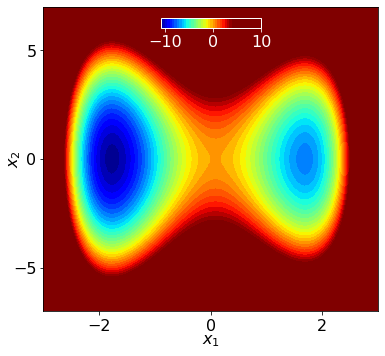

In [10]:
plot_potential(cbar=True, orientation='horizontal')

## Create training and validation datasets
- Markov chain Monte Carlo (MCMC) is used
- 10 000 steps for both right and left metastable state
- every 10th configuration is saved
- the same for validation dataset

This way by merging data for left and right metastable states we obtain 2000 samples in both training and validation datasets. 

In [11]:
from sampling import MetropolisGauss

In [12]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, sigma_metro=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.trajectory.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.trajectory.copy()

We also produce a set of states with $x_1 = 0$.
It will not be used in training. Only in analysis in order to visualize "border" between left and right state.

In [13]:
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['d']) * np.random.randn(1000)]).T

### Plot training datasatet together with "boundary" states

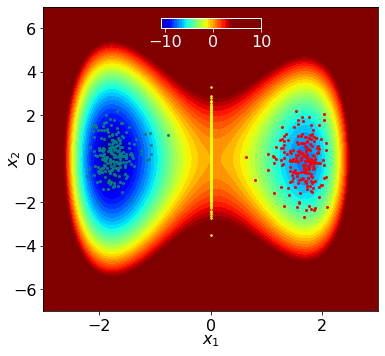

In [14]:
plot_potential(cbar=True, orientation='horizontal')
#plt.savefig(paper_dir + 'figs/double_well/potential2D_horizontal.pdf', bbox_inches='tight')
#plot_potential(cbar=True)
plt.plot(traj_left[::5, 0], traj_left[::5, 1], linewidth=0, marker='.', markersize=4, color='teal')
plt.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='yellow')
plt.plot(traj_right[::5, 0], traj_right[::5, 1], linewidth=0, marker='.', markersize=4, color='red')
plt.xlabel('$x_1$')
#plt.xlim(-3, 3)
plt.ylabel('$x_2$')
#plt.ylim(-4, 4)
plt.yticks([-6, -4, -2, 0, 2, 4, 6]);
#plt.savefig(paper_dir + 'figs/double_well/xdist.pdf', bbox_inches='tight', transparent=True)

## Preparation for training
### Parameters of the Boltzmann generators
We will always use the same BG parameters. We will only change method of training.
All our BGs will have 5 Real NVP layers.

In [15]:
bg_params = {
    "layers": 'R' * 4, 
    "energy_model": double_well,
    "nl_layers": 3
}

### Merge left and right training/validation datasets and define RC
$x_1$ is going to be used as reaction coordinate (RC).

In [16]:
training_dataset = np.vstack([traj_left, traj_right])
validation_dataset = np.vstack([traj_left_val, traj_right_val])


def get_x(x):
    return x[:, 0]

rc_loss_params = {
    "rc_function": get_x,
    "rc_min": -2.5,
    "rc_max": 2.5,
}

### Training script and script for latent interpolation

In [17]:
def train_bg(training_schedule):
    for args in training_shedule:
#     input("Can I continue in training? (press Enter)")
        current_loss_vals = bg.train(
            training_dataset,
            x_val = validation_dataset,
            weight_ML = args[0],
            weight_KL = args[1],
            weight_RCEnt = args[2],
            iterations = args[3],
            batch_size = args[4],
            lr = args[5],
            print_total_loss_only = True,
            **rc_loss_params
        )
    
    for loss_name in ["loss", "val_loss"]:
        plt.plot(current_loss_vals[loss_name], label=loss_name)
        
    plt.legend(loc='upper right')
    plt.show()

In [18]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

def plot_latent_interpolation(bg):
    xpaths = []
    for i in range(10):
        x1 = traj_left[np.random.randint(1000)] 
        x2 = traj_right[np.random.randint(1000)]
        xpaths.append(latent_interpolation(bg, x1, x2, nstep=1000))
        
    plot_potential(cbar=False, figsize=(5, 5))
    plt.xticks([])
    plt.xlabel('')
    plt.yticks([])
    plt.ylabel('')
    for xpath in xpaths:
        plt.plot(xpath[:, 0], xpath[:, 1], linewidth=2, color='white')

## Testing models with different training schedules
- ML loss = training by example
- KL loss = training by energy
- RC loss = training by increasing RC entropy

All scenarios start with 200 training iterations using solely ML.
After that, 400 steps is used using the method in the title.

In order to evaluate model 4 graphs are plotted:
- distribution of training data in $x$ together with "border" states (same for all models)
- mapping of these points to $z$ (prior) space of BG
- free energy profile obtained as $-kT \ln (p(x_1))$ where $p(x_1)$ is PDF produced by BG
- free energy profiled obtained when $p(x)$ is reweighted using weights $w(x) = e^{-u(x)}/p(x)$ (see the article)

For some of the models, we plot a so called latent interpolation as well:
- 10 pairs consisting of one state in right part and one state in left part of metastable states
- they are mapped to latent ($z$) space, where a linear interpolation is done
- this interpolating lines are mapped back to $x$, the result can be seen asi white lines

### Training by ML

In [19]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [20]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1, 0,  0,  200,  500,  1e-3],
                    [1, 0,  0,  400,  2000, 1e-3]]

Iteration 0/200: loss: 1.8571 val_loss: 1.7881 
Iteration 10/200: loss: 1.6090 val_loss: 1.5133 
Iteration 20/200: loss: 1.2661 val_loss: 1.2019 
Iteration 30/200: loss: 0.9325 val_loss: 1.0418 
Iteration 40/200: loss: 0.7545 val_loss: 0.7480 
Iteration 50/200: loss: 0.5665 val_loss: 0.6017 
Iteration 60/200: loss: 0.3905 val_loss: 0.4963 
Iteration 70/200: loss: 0.3428 val_loss: 0.3641 
Iteration 80/200: loss: 0.2973 val_loss: 0.2057 
Iteration 90/200: loss: 0.2084 val_loss: 0.1426 
Iteration 100/200: loss: 0.1674 val_loss: 0.1259 
Iteration 110/200: loss: 0.1914 val_loss: 0.1663 
Iteration 120/200: loss: 0.1388 val_loss: 0.3672 
Iteration 130/200: loss: 0.1189 val_loss: 0.1318 
Iteration 140/200: loss: 0.1969 val_loss: 0.1455 
Iteration 150/200: loss: 0.1069 val_loss: 0.1122 
Iteration 160/200: loss: 0.1884 val_loss: 0.3024 
Iteration 170/200: loss: 0.0828 val_loss: 0.1798 
Iteration 180/200: loss: 0.1062 val_loss: 0.1605 
Iteration 190/200: loss: 0.1299 val_loss: 0.2194 
Iteration 0

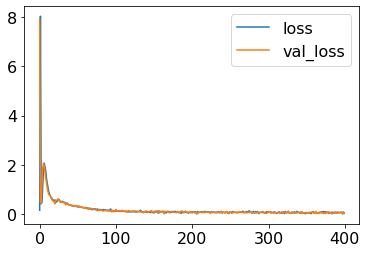

In [21]:
train_bg(bg)

../analysis.py:113: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Estimator Standard Error:  0.581914686647908


(<Figure size 1152x252 with 4 Axes>,
 array([<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:xlabel='$z_1$', ylabel='$z_2$'>,
        <AxesSubplot:xlabel='$x_1$', ylabel='Energy / kT'>,
        <AxesSubplot:xlabel='$x_1$'>], dtype=object))

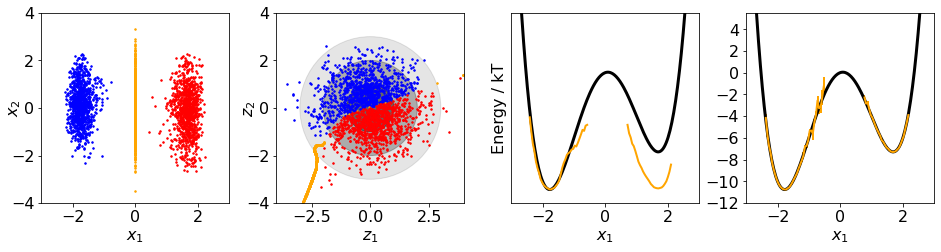

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [22]:
plot_network(bg)

### Training by KL

In [23]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [24]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1, 0,  0,  200,  500,  1e-3],
                    [0, 1,  0,  400,  2000, 1e-3]]

Iteration 0/200: loss: 2.0983 val_loss: 1.8854 
Iteration 10/200: loss: 1.4734 val_loss: 1.4950 
Iteration 20/200: loss: 1.3469 val_loss: 1.3577 
Iteration 30/200: loss: 1.1907 val_loss: 1.1825 
Iteration 40/200: loss: 0.9206 val_loss: 0.9231 
Iteration 50/200: loss: 0.5989 val_loss: 0.6815 
Iteration 60/200: loss: 0.4423 val_loss: 0.5227 
Iteration 70/200: loss: 0.3629 val_loss: 0.3578 
Iteration 80/200: loss: 0.2939 val_loss: 0.2156 
Iteration 90/200: loss: 0.2729 val_loss: 0.3265 
Iteration 100/200: loss: 0.1594 val_loss: 0.1613 
Iteration 110/200: loss: 0.1208 val_loss: 0.2554 
Iteration 120/200: loss: 0.1029 val_loss: 0.1388 
Iteration 130/200: loss: 0.2099 val_loss: 0.0954 
Iteration 140/200: loss: 0.1820 val_loss: 0.2252 
Iteration 150/200: loss: 0.1802 val_loss: 0.2886 
Iteration 160/200: loss: 0.1250 val_loss: 0.1215 
Iteration 170/200: loss: 0.1154 val_loss: 0.1492 
Iteration 180/200: loss: 0.2090 val_loss: 0.0434 
Iteration 190/200: loss: 0.1397 val_loss: 0.1088 
Iteration 0

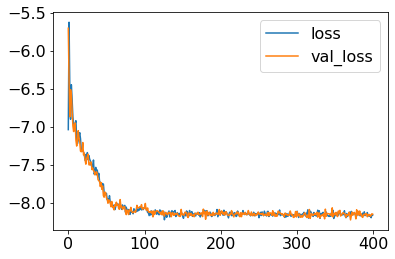

In [25]:
train_bg(training_shedule)

<ipython-input-8-283bae6019c3>:19: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(h) / temperature
../analysis.py:113: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Estimator Standard Error:  0.5560973852103981


(<Figure size 1152x252 with 4 Axes>,
 array([<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:xlabel='$z_1$', ylabel='$z_2$'>,
        <AxesSubplot:xlabel='$x_1$', ylabel='Energy / kT'>,
        <AxesSubplot:xlabel='$x_1$'>], dtype=object))

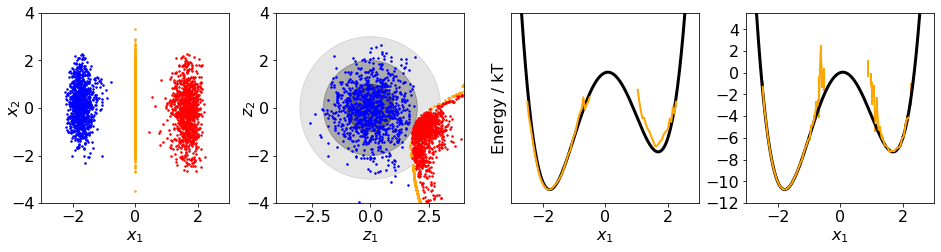

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [26]:
plot_network(bg)

### Training by ML + KL

In [27]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [28]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1, 0,  0,  200,  500,  1e-3],
                    [1, 1,  0,  400,  2000, 1e-3]]

Iteration 0/200: loss: 1.8255 val_loss: 1.7558 
Iteration 10/200: loss: 1.4482 val_loss: 1.4599 
Iteration 20/200: loss: 1.2291 val_loss: 1.1715 
Iteration 30/200: loss: 0.9580 val_loss: 0.8876 
Iteration 40/200: loss: 0.6826 val_loss: 0.7827 
Iteration 50/200: loss: 0.6055 val_loss: 0.5657 
Iteration 60/200: loss: 0.5016 val_loss: 0.4063 
Iteration 70/200: loss: 0.3618 val_loss: 0.2654 
Iteration 80/200: loss: 0.2619 val_loss: 0.4072 
Iteration 90/200: loss: 0.3261 val_loss: 0.3176 
Iteration 100/200: loss: 0.3004 val_loss: 0.2198 
Iteration 110/200: loss: 0.1784 val_loss: 0.1990 
Iteration 120/200: loss: 0.2889 val_loss: 0.1743 
Iteration 130/200: loss: 0.2233 val_loss: 0.1865 
Iteration 140/200: loss: 0.1599 val_loss: 0.2204 
Iteration 150/200: loss: 0.1353 val_loss: 0.1882 
Iteration 160/200: loss: 0.3073 val_loss: 0.2228 
Iteration 170/200: loss: 0.1577 val_loss: 0.1863 
Iteration 180/200: loss: 0.3317 val_loss: 0.1714 
Iteration 190/200: loss: 0.2246 val_loss: 0.3781 
Iteration 0

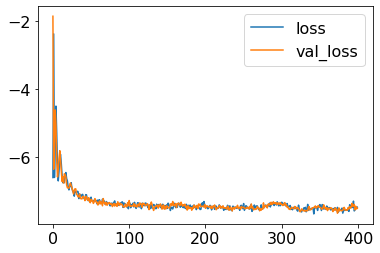

In [29]:
train_bg(training_shedule)

../analysis.py:113: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Estimator Standard Error:  0.4973331989165706


(<Figure size 1152x252 with 4 Axes>,
 array([<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:xlabel='$z_1$', ylabel='$z_2$'>,
        <AxesSubplot:xlabel='$x_1$', ylabel='Energy / kT'>,
        <AxesSubplot:xlabel='$x_1$'>], dtype=object))

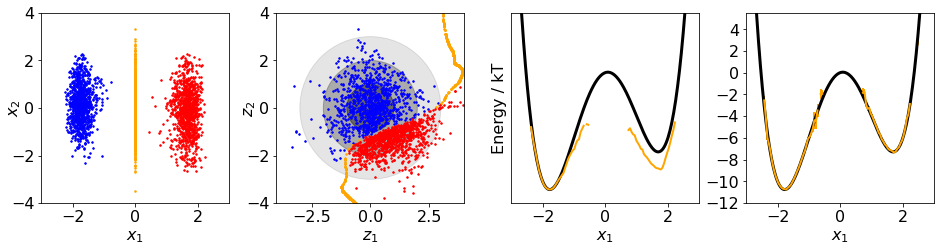

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [30]:
plot_network(bg)

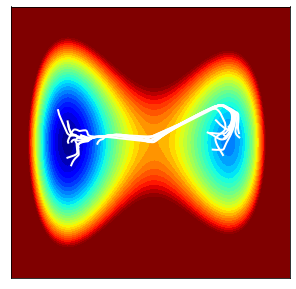

In [31]:
plot_latent_interpolation(bg)

### Training by ML + KL + RC

In [40]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [41]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1,    0, 0,  200, 500,  1e-3],
                    [1,    1, 1,  200, 2000, 1e-3],
                    [0.01, 1,  5, 200, 2000, 1e-3]]

Iteration 0/200: loss: 1.8961 val_loss: 1.9176 
Iteration 10/200: loss: 1.5609 val_loss: 1.5887 
Iteration 20/200: loss: 1.3668 val_loss: 1.4364 
Iteration 30/200: loss: 1.3218 val_loss: 1.3095 
Iteration 40/200: loss: 1.1610 val_loss: 1.1836 
Iteration 50/200: loss: 0.9372 val_loss: 0.9364 
Iteration 60/200: loss: 0.5674 val_loss: 0.5302 
Iteration 70/200: loss: 0.5097 val_loss: 0.3619 
Iteration 80/200: loss: 0.3880 val_loss: 0.3527 
Iteration 90/200: loss: 0.3405 val_loss: 0.1890 
Iteration 100/200: loss: 0.2126 val_loss: 0.3148 
Iteration 110/200: loss: 0.1629 val_loss: 0.2411 
Iteration 120/200: loss: 0.2454 val_loss: 0.2609 
Iteration 130/200: loss: 0.1646 val_loss: 0.2875 
Iteration 140/200: loss: 0.1485 val_loss: 0.1661 
Iteration 150/200: loss: 0.1334 val_loss: 0.2018 
Iteration 160/200: loss: 0.0779 val_loss: 0.1123 
Iteration 170/200: loss: 0.2057 val_loss: 0.1283 
Iteration 180/200: loss: 0.1692 val_loss: 0.1156 
Iteration 190/200: loss: 0.1040 val_loss: 0.0785 
Iteration 0

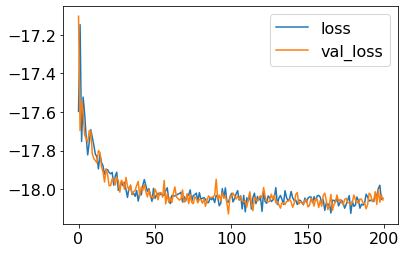

In [42]:
train_bg(training_shedule)

../analysis.py:113: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Estimator Standard Error:  0.14601688232653728


(<Figure size 1152x252 with 4 Axes>,
 array([<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:xlabel='$z_1$', ylabel='$z_2$'>,
        <AxesSubplot:xlabel='$x_1$', ylabel='Energy / kT'>,
        <AxesSubplot:xlabel='$x_1$'>], dtype=object))

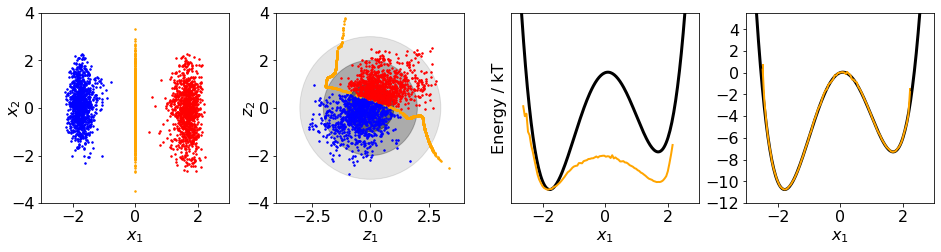

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [43]:
plot_network(bg)

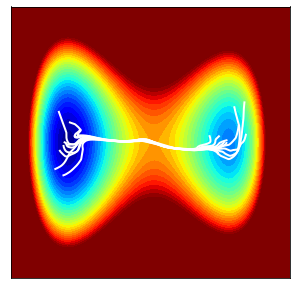

In [44]:
plot_latent_interpolation(bg)

### Training by ML + KL + (aggresive RC)

In [45]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [46]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1,    0,  0,  200,  500,  1e-3],
                    [0.01, 1,  3,  200,  2000, 1e-3],
                    [0.01, 1,  10, 200,  2000, 1e-3]]

Iteration 0/200: loss: 1.9800 val_loss: 1.7875 
Iteration 10/200: loss: 1.4730 val_loss: 1.4947 
Iteration 20/200: loss: 1.3274 val_loss: 1.3452 
Iteration 30/200: loss: 1.2759 val_loss: 1.2095 
Iteration 40/200: loss: 1.0011 val_loss: 0.9801 
Iteration 50/200: loss: 0.7083 val_loss: 0.6159 
Iteration 60/200: loss: 0.5367 val_loss: 0.5130 
Iteration 70/200: loss: 0.5038 val_loss: 0.4967 
Iteration 80/200: loss: 0.2890 val_loss: 0.2879 
Iteration 90/200: loss: 0.3388 val_loss: 0.2808 
Iteration 100/200: loss: 0.3460 val_loss: 0.2971 
Iteration 110/200: loss: 0.2260 val_loss: 0.2205 
Iteration 120/200: loss: 0.2419 val_loss: 0.2924 
Iteration 130/200: loss: 0.1721 val_loss: 0.3052 
Iteration 140/200: loss: 0.2746 val_loss: 0.1486 
Iteration 150/200: loss: 0.1833 val_loss: 0.1351 
Iteration 160/200: loss: 0.1055 val_loss: 0.1688 
Iteration 170/200: loss: 0.1435 val_loss: 0.1303 
Iteration 180/200: loss: 0.1918 val_loss: 0.2142 
Iteration 190/200: loss: 0.1077 val_loss: 0.1080 
Iteration 0

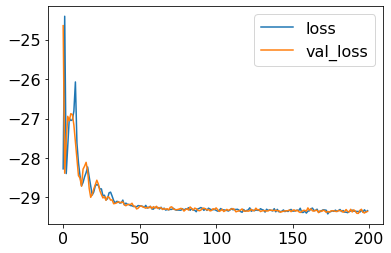

In [47]:
train_bg(training_shedule)

<ipython-input-8-283bae6019c3>:19: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(h) / temperature


Estimator Standard Error:  0.06618333742666684


(<Figure size 1152x252 with 4 Axes>,
 array([<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>,
        <AxesSubplot:xlabel='$z_1$', ylabel='$z_2$'>,
        <AxesSubplot:xlabel='$x_1$', ylabel='Energy / kT'>,
        <AxesSubplot:xlabel='$x_1$'>], dtype=object))

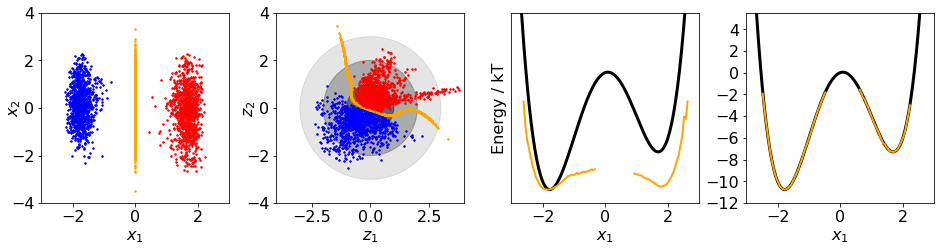

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [48]:
plot_network(bg)

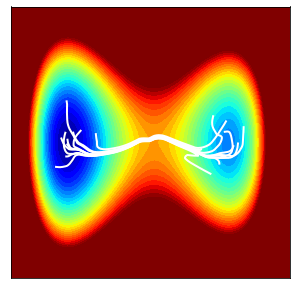

In [50]:
plot_latent_interpolation(bg)